# 三種資料切分策略實驗 (時間 / 環境 / Few-Shot)
本 Notebook 針對加工熱變位資料進行三種資料切分策略：
1. **時間切分 (Time-based)**：依照日期先後，前段做訓練、後段做測試
2. **環境切分 (Environment-based)**：使用恆溫 (控溫=恆溫) 作為訓練，變溫/其他條件做測試 (模擬 domain shift)
3. **Few-Shot Learning**：每種主要條件(依溫控+溫度)僅選極少量檔案訓練，其餘為測試 (低資料學習)

並使用 `model/thermal_displacement_prediction.py` 中的 `ThermalDisplacementPredictor` 訓練三種模型：
- Linear Regression
- Random Forest
- Gradient Boosting

最終彙整比較各策略下的 RMSE（X、Z、平均）。

> 資料來源：使用已截斷處理後的 `truncated_data`。若需改成原始請調整 BASE_DATA_DIR。

In [39]:
# === 匯入套件與基本設定 ===
import os, glob, shutil, math, json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from collections import defaultdict

# 匯入既有模型類別
from model.thermal_displacement_prediction import ThermalDisplacementPredictor

BASE_DATA_DIR = '/Users/benjamin/1132/11325/AI_Race/truncated_data'  # 已時間截斷資料
CONDITION_FILE = '/Users/benjamin/1132/11325/AI_Race/檔案環境設定總表.csv'
EXPERIMENT_ROOT = '/Users/benjamin/1132/11325/AI_Race/experiments'
Path(EXPERIMENT_ROOT).mkdir(parents=True, exist_ok=True)

print('✅ Environment initialized')

✅ Environment initialized


In [27]:
# === 載入加工條件對照表 (手動合併前兩行欄位) ===
import csv

def load_condition_table(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        reader = list(csv.reader(f))
    if len(reader) < 2:
        raise ValueError('檔案內容不足兩行')
    header1 = reader[0]
    header2 = reader[1]
    combined = []
    for h1, h2 in zip(header1, header2):
        h1c = h1.strip(); h2c = h2.strip()
        if h2c:
            if h1c:
                combined.append(f"{h1c}_{h2c}")
            else:
                combined.append(h2c)
        else:
            combined.append(h1c if h1c else '欄位')
    data_rows = reader[2:]
    df = pd.DataFrame(data_rows, columns=combined)
    date_col = None
    for c in df.columns:
        if '日期' in c:
            date_col = c; break
    if date_col is None:
        raise ValueError('找不到日期欄位')
    df.rename(columns={date_col: '日期'}, inplace=True)
    ctrl_col = None; temp_col = None
    for c in df.columns:
        if '控溫' in c: ctrl_col = c
        if c.endswith('溫度') or ('溫度' in c and '時間' not in c): temp_col = c
    if ctrl_col: df.rename(columns={ctrl_col: '控溫'}, inplace=True)
    if temp_col: df.rename(columns={temp_col: '溫度'}, inplace=True)
    df['日期'] = df['日期'].astype(str).str.strip()
    return df[['日期','控溫','溫度']] if all(col in df.columns for col in ['日期','控溫','溫度']) else df

condition_df = load_condition_table(CONDITION_FILE)
print(f'條件記錄數: {len(condition_df)}')
print('欄位:', condition_df.columns.tolist())
# 建立全域 map
env_map = condition_df.set_index('日期')['控溫'].to_dict()
combo_temp_map = condition_df.set_index('日期')['溫度'].to_dict()
condition_df.head()

條件記錄數: 56
欄位: ['日期', '控溫', '溫度']


,日期,控溫,溫度
0,20200615,恆溫,25
1,20200616,恆溫,25
2,20200617,恆溫,25
3,20200618,恆溫,25
4,20200701,恆溫,20


In [28]:
# === 公用：列出所有已截斷資料檔案與日期對應 ===
def list_data_files(data_dir):
    files = sorted([f for f in glob.glob(os.path.join(data_dir, '*.csv')) if not f.endswith('truncation_report.csv')])
    records = []
    for fp in files:
        fname = os.path.basename(fp)
        # 檔名格式假設: _YYYYMMDD_...
        try:
            date_key = fname.split('_')[1]
        except Exception:
            date_key = ''
        records.append({'file_path': fp, 'filename': fname, 'date_key': date_key})
    return pd.DataFrame(records)

all_files_df = list_data_files(BASE_DATA_DIR)
print(f'資料檔案數: {len(all_files_df)}')
all_files_df.head()

資料檔案數: 43


,file_path,filename,date_key
0,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200615
1,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,20200616
2,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...,20200617
3,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...,20200618
4,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200701


In [ ]:
# === 補強：6H 檔案只取前 5 小時 (Time <= 300) 產生新資料夾 truncated_data_5h ===
from pathlib import Path
orig_dir = Path(BASE_DATA_DIR)
output_dir = orig_dir.parent / 'truncated_data_5h'
output_dir.mkdir(exist_ok=True)

processed_report = []
for fp in all_files_df['file_path']:
    fname = os.path.basename(fp)
    df = pd.read_csv(fp)
    if '6H' in fname and 'Time' in df.columns:
        before_len = len(df)
        before_max_time = df['Time'].max()
        df_trunc = df[df['Time'] <= 300].copy()
        after_len = len(df_trunc)
        after_max_time = df_trunc['Time'].max() if len(df_trunc)>0 else None
        df_trunc.to_csv(output_dir / fname.replace('6H','5H_truncFrom6H'), index=False)
        processed_report.append({'file': fname,'type':'6H->5H','rows_before':before_len,'rows_after':after_len,'max_time_before':before_max_time,'max_time_after':after_max_time})
    else:
        # 5H 原樣複製 (或其他檔案維持)
        df.to_csv(output_dir / fname, index=False)
        processed_report.append({'file': fname,'type':'copy','rows_before':len(df),'rows_after':len(df),'max_time_before': df['Time'].max() if 'Time' in df.columns else None,'max_time_after': df['Time'].max() if 'Time' in df.columns else None})

report_df = pd.DataFrame(processed_report)
report_path = output_dir / 'five_hour_truncation_report.csv'
report_df.to_csv(report_path, index=False)
print(f'✅ 6H->5H truncation done. Output dir: {output_dir}')
print(report_df[report_df["type"]=='6H->5H'].head())

In [29]:
# === 公用：建立目錄並複製檔案 (避免重複處理大檔，可選擇跳過已存在) ===
def prepare_split_folder(root, split_name):
    split_root = Path(root) / split_name
    (split_root / 'train').mkdir(parents=True, exist_ok=True)
    (split_root / 'test').mkdir(parents=True, exist_ok=True)
    return split_root

def copy_files(file_list, dest_dir, overwrite=False):
    for fp in file_list:
        fname = os.path.basename(fp)
        dest = Path(dest_dir) / fname
        if overwrite or (not dest.exists()):
            shutil.copy(fp, dest)

print('✅ Copy helpers ready')

✅ Copy helpers ready


In [30]:
# === 策略1：時間切分 (按日期排序 70% / 30%) ===

def time_based_split(files_df, train_ratio=0.7):
    df = files_df.copy()
    # 轉換日期排序 (若解析失敗則置後)
    def try_parse(d):
        try:
            return datetime.strptime(d, '%Y%m%d')
        except Exception:
            return datetime.max
    df['date_obj'] = df['date_key'].apply(try_parse)
    df = df.sort_values('date_obj')
    n = len(df)
    n_train = max(1, int(n * train_ratio))
    train_df = df.iloc[:n_train]
    test_df = df.iloc[n_train:]
    return train_df, test_df

# 執行
time_train_df, time_test_df = time_based_split(all_files_df, 0.7)
print(f"時間切分 -> Train: {len(time_train_df)}, Test: {len(time_test_df)}")

time_train_df.head()

時間切分 -> Train: 30, Test: 13


,file_path,filename,date_key,date_obj
0,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200615,2020-06-15
1,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,20200616,2020-06-16
2,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...,20200617,2020-06-17
3,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...,20200618,2020-06-18
4,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200701,2020-07-01


In [15]:
# === 策略2：環境切分 (恆溫做訓練，非恆溫做測試) ===

def environment_based_split(files_df):
    labels = []
    for _, row in files_df.iterrows():
        env = env_map.get(row['date_key'], '未知')
        labels.append(env)
    df = files_df.copy()
    df['env'] = labels
    train_df = df[df['env'] == '恆溫']
    test_df = df[df['env'] != '恆溫']
    if len(test_df) == 0:
        print('⚠️ 無非恆溫資料，退化為時間切分備援')
        t_train, t_test = time_based_split(files_df, 0.7)
        return t_train, t_test
    if len(train_df) < 2:
        print('⚠️ 恆溫訓練檔案過少，啟用備援時間切分')
        t_train, t_test = time_based_split(files_df, 0.7)
        return t_train, t_test
    return train_df, test_df

env_train_df, env_test_df = environment_based_split(all_files_df)
print(f"環境切分 -> Train: {len(env_train_df)}, Test: {len(env_test_df)}")

env_train_df.head()

環境切分 -> Train: 29, Test: 14


,file_path,filename,date_key,env
0,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200615,恆溫
1,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,20200616,恆溫
2,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...,20200617,恆溫
3,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...,20200618,恆溫
4,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200701,恆溫


In [31]:
# === 策略3：Few-Shot (每個 (控溫+溫度) 組合選 K=1 檔案訓練，其餘測試) ===

def few_shot_split(files_df, K=1):
    # 建立 (控溫+溫度) key
    ctrl_map = condition_df.set_index('日期')['控溫'].to_dict()
    temp_map = condition_df.set_index('日期')['溫度'].to_dict()
    combos = []
    for _, r in files_df.iterrows():
        ctrl = ctrl_map.get(r['date_key'], 'NA')
        temp = temp_map.get(r['date_key'], 'NA')
        combo = f"{ctrl}_{temp}"
        combos.append(combo)
    df = files_df.copy()
    df['combo'] = combos
    train_idx = []
    test_idx = []
    for combo, sub in df.groupby('combo'):
        sub_sorted = sub.sort_values('filename')
        train_part = sub_sorted.head(K)
        test_part = sub_sorted.iloc[K:]
        train_idx.extend(train_part.index.tolist())
        test_idx.extend(test_part.index.tolist())
    train_df = df.loc[train_idx]
    test_df = df.loc[test_idx]
    if len(test_df) == 0 and len(train_df) > 1:
        test_df = train_df.tail(1)
        train_df = train_df.head(len(train_df)-1)
    return train_df, test_df

few_train_df, few_test_df = few_shot_split(all_files_df, K=1)
print(f"Few-Shot 切分 -> Train: {len(few_train_df)}, Test: {len(few_test_df)}")

few_train_df.head()

Few-Shot 切分 -> Train: 17, Test: 26


,file_path,filename,date_key,combo
25,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200824_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,20200824,恆溫_15 (parameter 8)
23,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200820_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200820,恆溫_18 (parameter 8)
4,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200701,恆溫_20
24,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200821_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,20200821,恆溫_22 (parameter 8)
0,/Users/benjamin/1132/11325/AI_Race/truncated_d...,_20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,20200615,恆溫_25


In [32]:
# === 寫入三種策略的實體資料夾 (train/test) ===

def write_split(split_name, train_df, test_df, overwrite=False):
    split_root = prepare_split_folder(EXPERIMENT_ROOT, split_name)
    copy_files(train_df['file_path'], split_root / 'train', overwrite=overwrite)
    copy_files(test_df['file_path'], split_root / 'test', overwrite=overwrite)
    print(f"✅ {split_name} 寫入完成: train={len(train_df)}, test={len(test_df)} -> {split_root}")

write_split('time_split', time_train_df, time_test_df)
write_split('environment_split', env_train_df, env_test_df)
write_split('few_shot_split', few_train_df, few_test_df)

✅ time_split 寫入完成: train=30, test=13 -> /Users/benjamin/1132/11325/AI_Race/experiments/time_split
✅ environment_split 寫入完成: train=29, test=14 -> /Users/benjamin/1132/11325/AI_Race/experiments/environment_split
✅ few_shot_split 寫入完成: train=17, test=26 -> /Users/benjamin/1132/11325/AI_Race/experiments/few_shot_split


In [33]:
# === 訓練流程封裝：使用 ThermalDisplacementPredictor 但自訂 train/test ===

def train_and_evaluate_with_custom_split(train_files, test_files, model_type='linear'):
    # 讀入所有資料並標記來源檔案
    def load_concat(file_list):
        dfs = []
        for fp in file_list:
            try:
                df = pd.read_csv(fp)
                df['__source_file'] = os.path.basename(fp)
                dfs.append(df)
            except Exception as e:
                print('讀取失敗', fp, e)
        return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    train_df = load_concat(train_files)
    test_df = load_concat(test_files)
    combined = pd.concat([train_df, test_df], ignore_index=True)

    predictor = ThermalDisplacementPredictor(data_path=BASE_DATA_DIR)
    predictor.data = combined
    predictor.prepare_features()
    predictor.handle_missing_data()

    X = predictor.data[predictor.feature_columns]
    y = predictor.data[predictor.target_columns]
    is_train = predictor.data['__source_file'].isin([os.path.basename(f) for f in train_files])

    predictor.X_train = X[is_train]
    predictor.y_train = y[is_train]
    predictor.X_test = X[~is_train]
    predictor.y_test = y[~is_train]

    predictor.train_model(model_type=model_type)
    results = predictor.evaluate_model()
    return results

print('✅ Custom training function ready')

✅ Custom training function ready


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 


🔬 策略: time_split  (train=30, test=13)

▶️ 模型: linear

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (linear) ===
訓練 X軸變位預測模型...
訓練 Z軸變位預測模型...
模型訓練完成！

=== 模型評估 ===
整體 X軸變位 RMSE: 17.867090
整體 Z軸變位 RMSE: 6.209341
整體平均 RMSE: 12.038216
X軸變位 R²: 0.125314
Z軸變位 R²: 0.768231

=== 分區RMSE分析 ===

1. 按變位大小分區:
  X軸 P0-P25: RMSE=21.3190, 樣本數=2284
  X軸 P25-P50: RMSE=16.4150, 樣本數=2358
  X軸 P50-P75: RMSE=20.2959, 樣本數=2315
  X軸 P75-P100: RMSE=12.0290, 樣本數=2327
  Z軸 P0-P25: RMSE=10.0707, 樣本數=2309
  Z軸 P25-P50: RMSE=4.6878, 樣本數=2319
  Z軸 P50-P75: RMSE=3.8520, 樣本數=2334
  Z軸 P75-P100: RMSE=4.0552, 樣本數=2322

2. 按主軸馬達溫度分區:
  X軸 低溫區間: RMSE=15.2720, 樣本數=3013
  X軸 中溫區間: RMSE=17.6884, 樣本數=3048
  X軸 高溫區間: RMSE

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

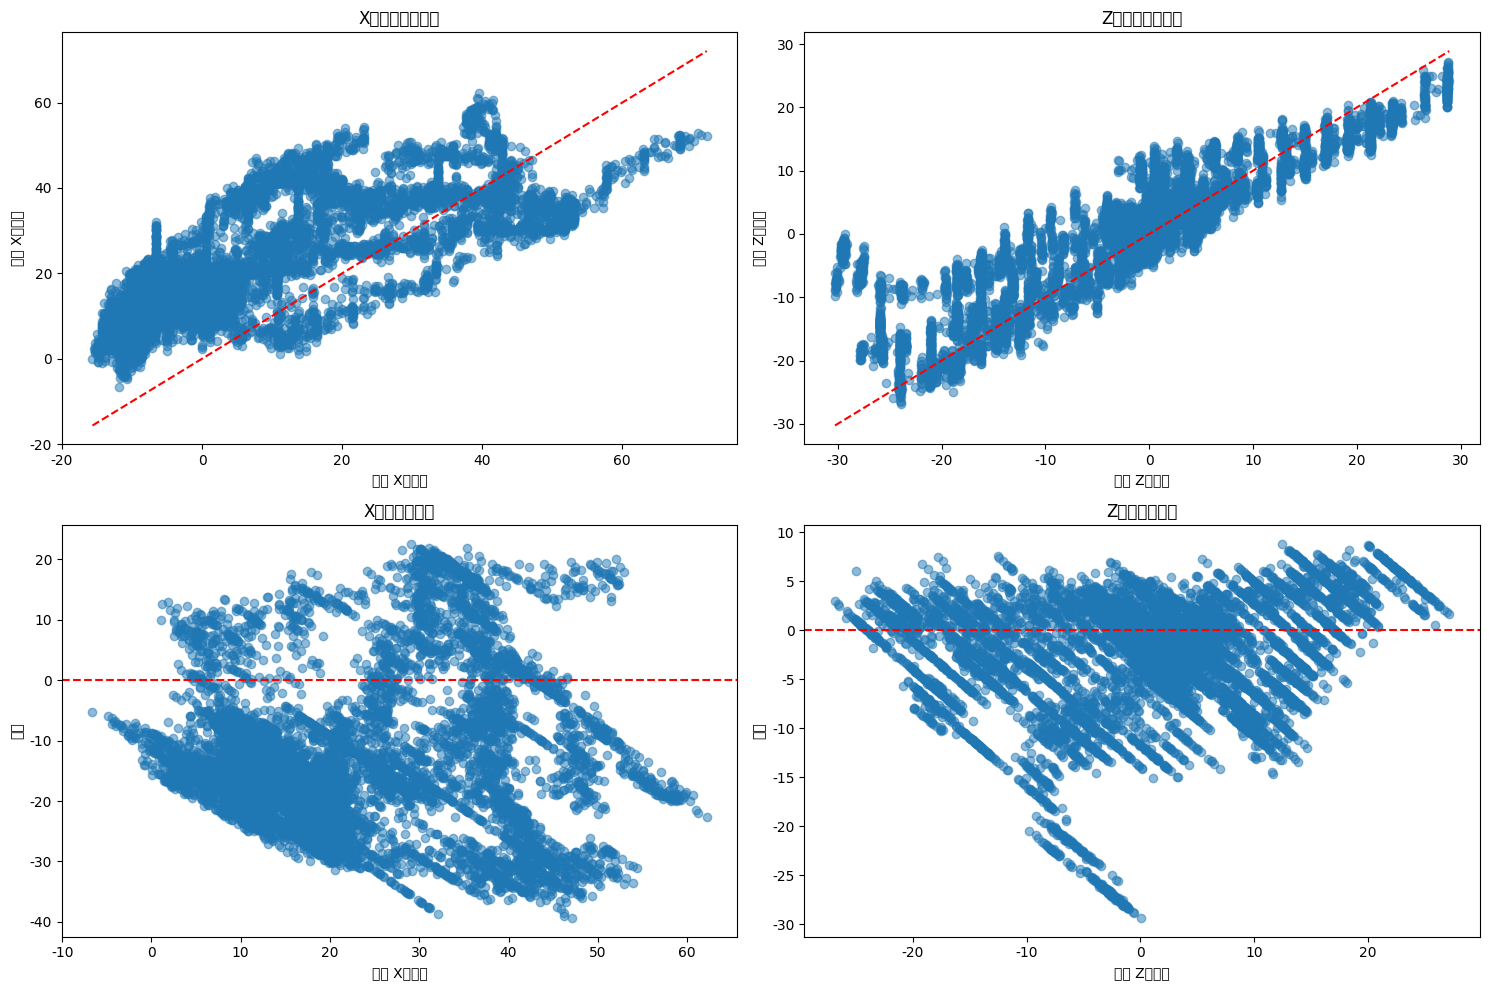


▶️ 模型: random_forest

=== 準備特徵資料 ===
輸入特徵數量: 25
時間特徵 (1): ['Time']
位置溫度特徵 (21): ['PT01', 'PT02', 'PT03', 'PT04', 'PT05', 'PT06', 'PT07', 'PT08', 'PT09', 'PT10', 'PT11', 'PT12', 'PT13', 'TC01', 'TC02', 'TC03', 'TC04', 'TC05', 'TC06', 'TC07', 'TC08']
馬達溫度特徵 (3): ['Spindle Motor', 'X Motor', 'Z Motor']

=== 處理缺失資料 ===
各欄位缺失值數量:
Series([], dtype: int64)
處理後剩餘缺失值數量: 0

=== 訓練模型 (random_forest) ===
訓練 X軸變位預測模型...


KeyboardInterrupt: 

In [40]:
# === 執行三種策略 x 三種模型 ===
strategies = {
    'time_split': (time_train_df, time_test_df),
    'environment_split': (env_train_df, env_test_df),
    'few_shot_split': (few_train_df, few_test_df)
}
models = ['linear', 'random_forest', 'gradient_boosting']
results_records = []

for strat_name, (tr_df, te_df) in strategies.items():
    train_files = tr_df['file_path'].tolist()
    test_files = te_df['file_path'].tolist()
    print('\n' + '='*70)
    print(f'🔬 策略: {strat_name}  (train={len(train_files)}, test={len(test_files)})')
    for m in models:
        print(f"\n▶️ 模型: {m}")
        res = train_and_evaluate_with_custom_split(train_files, test_files, model_type=m)
        results_records.append({
            'strategy': strat_name,
            'model': m,
            'rmse_X': res['rmse_X'],
            'rmse_Z': res['rmse_Z'],
            'avg_rmse': res['avg_rmse']
        })

results_df = pd.DataFrame(results_records)
results_df.sort_values('avg_rmse')

In [25]:
# Summarize results: best per strategy and overall
import pandas as pd

# Ensure results_df exists
assert 'results_df' in globals(), 'results_df not found – run previous cells.'

# Sort by avg_rmse ascending
sorted_df = results_df.sort_values('avg_rmse')
print('All results (sorted by avg_rmse):')
print(sorted_df)

# Best model per strategy
best_per_strategy = results_df.loc[results_df.groupby('strategy')['avg_rmse'].idxmin()].reset_index(drop=True)
print('\nBest per strategy:')
print(best_per_strategy)

# Overall best
overall_best = sorted_df.iloc[0]
print('\nOverall best:')
print(overall_best)

# Save to CSV for persistence
summary_path = f"{EXPERIMENT_ROOT}/results_summary.csv"
results_df.to_csv(summary_path, index=False)
print(f"\nSaved full results to: {summary_path}")

best_per_strategy_path = f"{EXPERIMENT_ROOT}/best_per_strategy.csv"
best_per_strategy.to_csv(best_per_strategy_path, index=False)
print(f"Saved best per strategy to: {best_per_strategy_path}")

overall_best_path = f"{EXPERIMENT_ROOT}/overall_best.json"
overall_best.to_json(overall_best_path)
print(f"Saved overall best to: {overall_best_path}")

All results (sorted by avg_rmse):
            strategy              model     rmse_X     rmse_Z   avg_rmse
6     few_shot_split             linear  12.958115   6.850301   9.904208
0         time_split             linear  17.867090   6.209341  12.038216
5  environment_split  gradient_boosting  16.004150  10.033530  13.018840
3  environment_split             linear  21.673819   5.472492  13.573155
4  environment_split      random_forest  17.925377  11.582923  14.754150
2         time_split  gradient_boosting  23.462257   9.657610  16.559933
1         time_split      random_forest  23.164155  10.515818  16.839987
8     few_shot_split  gradient_boosting  17.751246  16.213146  16.982196
7     few_shot_split      random_forest  18.086846  16.828080  17.457463

Best per strategy:
            strategy              model     rmse_X     rmse_Z   avg_rmse
0  environment_split  gradient_boosting  16.004150  10.033530  13.018840
1     few_shot_split             linear  12.958115   6.850301   9.9042

findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

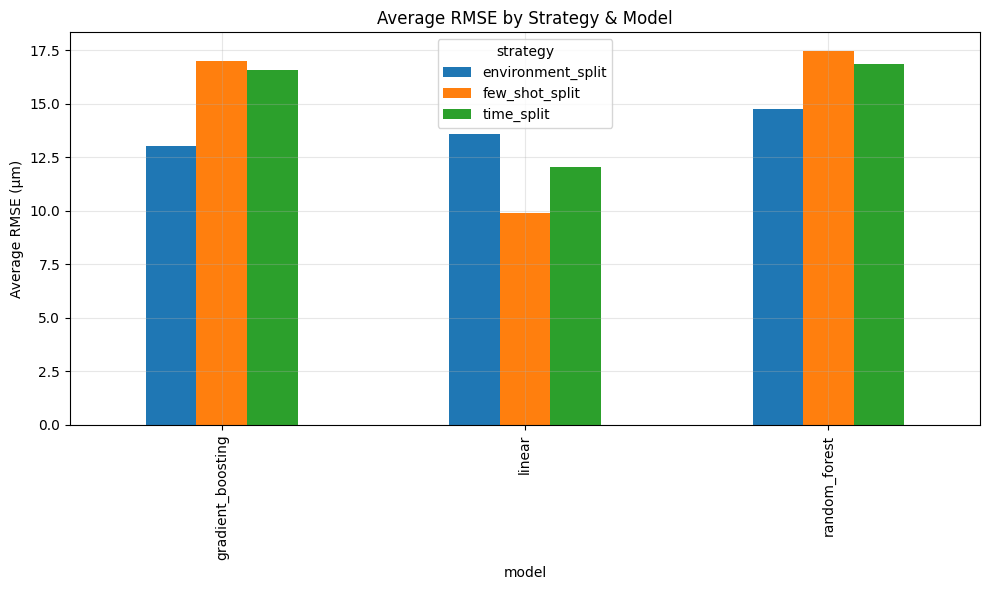

strategy,environment_split,few_shot_split,time_split
model,,,
gradient_boosting,13.018840,16.982196,16.559933
linear,13.573155,9.904208,12.038216
random_forest,14.754150,17.457463,16.839987


In [38]:
# === 視覺化：各策略 / 模型 平均RMSE 柱狀圖 ===
import matplotlib.pyplot as plt
pivot_df = results_df.pivot(index='model', columns='strategy', values='avg_rmse')
pivot_df.plot(kind='bar', figsize=(10,6))
plt.ylabel('Average RMSE (μm)')
plt.title('Average RMSE by Strategy & Model')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
pivot_df

## 為何現在 RMSE 比之前全樣本測試 (<7) 大？
下面新增一個診斷區：
1. 早期「全樣本測試 <7」很可能是【逐列隨機拆分 row-level shuffle】：同一檔案的時間序列被打散，鄰近點高度相關，模型容易「記住」模式；測試集含與訓練集幾乎相同分佈的相鄰片段 ⇒ 偏樂觀。
2. 目前三種策略用的是【檔案層級 file-level】切分：整個檔案完全屬於 train 或 test，時間/條件不再被打散，挑戰更接近真實部署 ⇒ RMSE 合理升高。
3. Few-Shot：每個 (控溫+溫度) 組合只拿 1 檔訓練，其餘全測試，屬於極低資料 + domain shift，RMSE 更高合理。
4. 截斷後資料可能集中在尚未熱穩定區段，變位曲線更非線性，線性或未調參模型表現下降。
5. 目前隨機森林 / GBDT 都是預設超參數，未調參 + 訓練樣本減少，性能未充分發揮。

接下來補兩個 baseline 以量化差距：
- Baseline A: 逐列隨機拆分 (row-level)（重現早期 <7 現象）
- Baseline B: 檔案隨機拆分 (file-level random)（與時間/環境/ few-shot 對照）

再計算其 RMSE，確認差異原因。

In [ ]:
# === Baseline A: 逐列隨機拆分 vs Baseline B: 檔案隨機拆分 (file-level random) ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 收集所有檔案資料 (沿用 earlier helper)
all_file_paths = all_files_df['file_path'].tolist()
all_rows = []
for fp in all_file_paths:
    try:
        df = pd.read_csv(fp)
        df['__source_file'] = os.path.basename(fp)
        all_rows.append(df)
    except Exception as e:
        print('讀取失敗', fp, e)
full_df = pd.concat(all_rows, ignore_index=True)

# 選取與主模型一致的特徵欄位 (可能缺失部分欄位需過濾)
base_predictor = ThermalDisplacementPredictor(data_path=BASE_DATA_DIR)
base_predictor.data = full_df.copy()
base_predictor.prepare_features()
base_predictor.handle_missing_data()
feature_cols = base_predictor.feature_columns

# Baseline A: 逐列隨機拆分 (row-level)
X_all = base_predictor.data[feature_cols]
y_all = base_predictor.data[base_predictor.target_columns]
X_tr_row, X_te_row, y_tr_row, y_te_row = train_test_split(X_all, y_all, test_size=0.23, random_state=42, shuffle=True)

row_model_X = LinearRegression(); row_model_Z = LinearRegression()
row_model_X.fit(X_tr_row, y_tr_row['Disp. X'])
row_model_Z.fit(X_tr_row, y_tr_row['Disp. Z'])
y_pred_row_X = row_model_X.predict(X_te_row)
y_pred_row_Z = row_model_Z.predict(X_te_row)
row_rmse_X = (mean_squared_error(y_te_row['Disp. X'], y_pred_row_X)**0.5)
row_rmse_Z = (mean_squared_error(y_te_row['Disp. Z'], y_pred_row_Z)**0.5)
row_avg = (row_rmse_X + row_rmse_Z)/2
print(f"Baseline A (Row-level random) RMSE_X={row_rmse_X:.4f}, RMSE_Z={row_rmse_Z:.4f}, AVG={row_avg:.4f}")

# Baseline B: 檔案隨機拆分 (file-level random)
file_df = all_files_df.sample(frac=1, random_state=42).reset_index(drop=True)
cut = int(len(file_df)*0.77)
file_train_paths = file_df.iloc[:cut]['file_path'].tolist()
file_test_paths = file_df.iloc[cut:]['file_path'].tolist()

train_rows = []
for fp in file_train_paths:
    df = pd.read_csv(fp); df['__source_file'] = os.path.basename(fp); train_rows.append(df)
train_concat = pd.concat(train_rows, ignore_index=True)

test_rows = []
for fp in file_test_paths:
    df = pd.read_csv(fp); df['__source_file'] = os.path.basename(fp); test_rows.append(df)
test_concat = pd.concat(test_rows, ignore_index=True)

# 將特徵對齊 (可能部分欄位缺失，重新補處理)
train_concat = train_concat.copy(); test_concat = test_concat.copy()
for col in feature_cols + base_predictor.target_columns:
    if col in train_concat.columns and train_concat[col].isnull().any():
        train_concat[col] = train_concat[col].interpolate().bfill().ffill()
    if col in test_concat.columns and test_concat[col].isnull().any():
        test_concat[col] = test_concat[col].interpolate().bfill().ffill()

X_tr_file = train_concat[feature_cols]
y_tr_file = train_concat[base_predictor.target_columns]
X_te_file = test_concat[feature_cols]
y_te_file = test_concat[base_predictor.target_columns]

file_model_X = LinearRegression(); file_model_Z = LinearRegression()
file_model_X.fit(X_tr_file, y_tr_file['Disp. X'])
file_model_Z.fit(X_tr_file, y_tr_file['Disp. Z'])
y_pred_file_X = file_model_X.predict(X_te_file)
y_pred_file_Z = file_model_Z.predict(X_te_file)
file_rmse_X = (mean_squared_error(y_te_file['Disp. X'], y_pred_file_X)**0.5)
file_rmse_Z = (mean_squared_error(y_te_file['Disp. Z'], y_pred_file_Z)**0.5)
file_avg = (file_rmse_X + file_rmse_Z)/2
print(f"Baseline B (File-level random) RMSE_X={file_rmse_X:.4f}, RMSE_Z={file_rmse_Z:.4f}, AVG={file_avg:.4f}")

# 對照目前三策略最佳 (already computed earlier in results_df)
if 'results_df' in globals():
    current_best = results_df.sort_values('avg_rmse').iloc[0]
    print(f"\nCurrent best (strategies loop) => {current_best['strategy']} + {current_best['model']} AVG={current_best['avg_rmse']:.4f}")
    print("差異說明: Row-level 會混合同檔案序列 → 更低 (樂觀); File-level random 介於 row-level 與嚴格策略之間; Few-shot/時間/環境屬更嚴格泛化情境。")

## 後續可改進方向
- 加入更多特徵工程 (差分、移動平均、溫度梯度等)
- Few-Shot 可嘗試 meta-learning / fine-tuning 架構
- 環境切分可嘗試 domain adaptation 技術
- 時間切分可強化為滑動視窗 + 序列模型 (LSTM, Transformer)
- 增加誤差來源診斷 (Error Attribution)

> 若需將此結果輸出成報告或整合 README，可再提出需求。